# Load Dependencies


In [1]:
# %load_ext autoreload
# %autoreload 2
# %reload_ext autoreload

import matplotlib.pyplot as plt

import torch

import pyciemss
from pyciemss.PetriNetODE.interfaces import setup_model, reset_model, intervene, sample, calibrate, optimize, load_petri_model
import mira
from pyciemss.utils import get_tspan
from pyciemss.utils import setup_ax, plot_predictive, plot_trajectory, plot_intervention_line, sideaxis, sideaxishist

from pyciemss.risk.risk_measures import alpha_quantile, alpha_superquantile
from pyciemss.risk.ouu import computeRisk, solveOUU
from pyciemss.risk.qoi import nday_rolling_average
import numpy as np
import time

import warnings
warnings.filterwarnings('ignore')

import copy

# Plotting Utilities (moved to utilities to avoid repetition in notebooks)
The following cell can be deleted after review of utilities.


In [2]:

# def setup_ax(ax=None):

#     if not ax:
#         fig = plt.figure(facecolor='w', figsize=(9, 9))
#         ax = fig.add_subplot(111, axisbelow=True)

#     ax.set_xlabel('Time /days') #I think labeling this 'Time (days)' is a bit more clear, Time/days => time per days
#     ax.set_ylabel('Infected (1000s)') #This is fine but epi-people often use "per 100,000." This is nitpicky also, but try to use "infectious" rather than infected.
#     return ax

# def plot_predictive(prediction, tspan, tmin=None, ax=None, alpha=0.2, color="black", **kwargs):
#     vars = ["I_obs"]
    
#     I_low = torch.quantile(prediction["I_obs"], 0.05, dim=0).detach().numpy()
#     I_up = torch.quantile(prediction["I_obs"], 0.95, dim=0).detach().numpy()

#     if tmin:
#         indeces = tspan >= tmin
#     else:
#         indeces = torch.ones_like(tspan).bool()

#     if not ax:
#         fig = plt.figure(facecolor='w')
#         ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    
#     ax.fill_between(tspan[indeces], I_low[indeces], I_up[indeces], alpha=alpha, color=color, **kwargs)

#     legend = ax.legend()
#     legend.get_frame().set_alpha(0.5)

#     return ax

# def plot_trajectory(data, tspan,  ax=None, color='black', alpha=0.5, lw=0, marker='.', label=None, ):
#     # Plot the data on three separate curves for S(t), I(t) and R(t)

#     if not ax:
#         fig = plt.figure(facecolor='w')
#         ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

#     ax.plot(tspan, data["I_obs"].squeeze().detach().numpy(), color, alpha=alpha, lw=lw, marker=marker, label=label)
    
#     return ax

# def plot_intervention_line(t, ax=None):
#     if not ax:
#         fig = plt.figure(facecolor='w')
#         ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

#     ylim = ax.get_ylim()

#     ax.vlines(t, min(ylim), max(ylim), color="grey", ls='-')

#     return ax

# Setup Parameters


In [3]:

full_tspan = get_tspan(1, 89, 89) #bad idea

num_samples = 10

# Total population, N.
N = 100000.0
# Initial number of infected and recovered individuals, I0 and R0.
V0, I0, Iv0, R0 = 0., 81.0, 0., 0. #may want to revisit this choice, consider setting I0 to 1 (there will not be zero recovered people when there are 81 infectious people)
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - Iv0 - V0 - R0

# 18 - 24 year olds
plot_I_obs = dict(I_obs=torch.tensor([81.47, 84.3, 86.44, 89.66, 93.32, 94.1, 96.31])) #these numbers make no sense, why not use whole numbers?
I_obs = [(float(i+1), dict(I_obs=obs/N)) for i, obs in enumerate([81.47, 84.3, 86.44, 89.66, 93.32, 94.1, 96.31])]

observed_tspan = get_tspan(1, len(I_obs), len(I_obs)) #also bad

# named_initial_state = {
#     "S": torch.as_tensor(S0),
#     "V": torch.as_tensor(V0),
#     "I": torch.as_tensor(I0),
#     "I_v": torch.as_tensor(Iv0),
#     "R": torch.as_tensor(R0),
# }

# named_final_state = {
#     "S": torch.as_tensor(S0),
#     "V": torch.as_tensor(V0),
#     "I": I_obs[-1],
#     "I_v": torch.as_tensor(Iv0),
#     "R": torch.as_tensor(R0),
# }
I_obs

[(1.0, {'I_obs': 0.0008147}),
 (2.0, {'I_obs': 0.000843}),
 (3.0, {'I_obs': 0.0008644}),
 (4.0, {'I_obs': 0.0008966}),
 (5.0, {'I_obs': 0.0009331999999999999}),
 (6.0, {'I_obs': 0.000941}),
 (7.0, {'I_obs': 0.0009631})]

# Probabilistic Forecasting - Ignoring Historical Data

#### Do we need the code bits in the markdowns below?
import json #this doesn't work??
  
petri_net_ode_model = load_petri_model('../../test/models/SVIIvR.json')
petri_net_ode_model

from pyciemss.PetriNetODE.models import MIRA_SVIIvR
petri_net_ode_model = MIRA_SVIIvR.from_mira('../../test/models/SVIIvR.json')

from pyciemss.PetriNetODE.models import MIRA_I_obs_with_scaled_Gaussian_noise
petri_net_ode_model = MIRA_I_obs_with_scaled_Gaussian_noise.from_mira('../../test/models/SVIIvR.json')
petri_net_ode_model.total_population = N
petri_net_ode_model.data_reliability = 4.0
petri_net_ode_model

from mira.examples.chime import sviivr
dir(sviivr)

import json
with open('../../test/models/chime.sviivr.json', 'w') as out:
    out.write(sviivr.json())
    


from pyciemss.PetriNetODE.models import MIRA_I_obs_with_scaled_Gaussian_noise
petri_net_ode_model = MIRA_I_obs_with_scaled_Gaussian_noise.from_mira('../../test/models/chime.sviivr.json')
petri_net_ode_model.total_population = N
petri_net_ode_model.data_reliability = 4.0
petri_net_ode_model

## Load the model

In [4]:
from pyciemss.PetriNetODE.models import MIRA_I_obs_with_scaled_Gaussian_noise
model_json = '../../test/models/SVIIvR_mira.json'
petri_net_ode_model = MIRA_I_obs_with_scaled_Gaussian_noise.from_mira(model_json)
petri_net_ode_model.total_population = N
petri_net_ode_model.data_reliability = 4.0
petri_net_ode_model

MIRA_I_obs_with_scaled_Gaussian_noise(
	beta = Uniform(low: 0.18000000715255737, high: 0.2199999988079071),
	betaV = Uniform(low: 0.03375000134110451, high: 0.04125000163912773),
	nu = Uniform(low: 0.0044999998062849045, high: 0.005499999970197678),
	gamma = Uniform(low: 0.1574999988079071, high: 0.19249999523162842),
	gammaV = Uniform(low: 0.22499999403953552, high: 0.2750000059604645),
	total_population = 100000.0,
	data_reliability = 4.0
)

## Can we remove the next two cells?
from pyciemss.PetriNetODE.base import SVIIvRPetriNetODESystem
petri_net_ode_model = SVIIvRPetriNetODESystem.from_mira('../../test/models/SVIIvR.json')

petri_net_model = load_petri_model(model_json)
petri_net_model

## Initialize

In [5]:
initialized_petri_net_ode_model = setup_model(petri_net_ode_model, start_time=0.0, start_state=dict(S=S0, V=V0, I=I0, I_v=Iv0, R=R0))
#this is giving the wrong documentation string

## Q: "What likely future outcomes does our model imply?"

### Sample a single trajectory from the prior distribution

In [6]:
single_prior = sample(initialized_petri_net_ode_model, timepoints=full_tspan, num_samples=1)
single_prior['I_obs'] = single_prior['I_sol'] + single_prior['I_v_sol']

KeyboardInterrupt: 

### Sample 100 trajectories from the prior distribution

In [ ]:
prior_prediction = sample(initialized_petri_net_ode_model, timepoints=full_tspan, num_samples=100)
prior_prediction['I_obs'] = prior_prediction['I_sol'] + prior_prediction['I_v_sol']

In [ ]:
#ax = plot_trajectory(solutions['single_hand_ode_model']['I'], full_tspan, ax=setup_ax(), color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast (manual)")
#ax = plot_predictive(solutions['hand_ode_model']['I'], full_tspan, ax=ax, label="Before Seeing Data - Probabilistic Forecast (manual)", color="red", alpha=0.5)
ax = plot_trajectory(single_prior, full_tspan, ax=setup_ax(), color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast (MIRA)")
ax = plot_predictive(prior_prediction, full_tspan, ax=ax, label="Before Seeing Data - Probabilistic Forecast (MIRA)", color="red", alpha=0.2)
#ax.set_ylim(0, 105)

## Forecasting - Incorporating Historical Data

### Calibration

In [ ]:
data = [(float(i+1), dict(I_obs=obs)) for i, obs in enumerate([81.47, 84.3, 86.44, 89.66, 93.32, 94.1, 96.31])]
calibrated_parameters = calibrate(initialized_petri_net_ode_model, data=data, verbose=True)

## Generated samples from the calibrated parameters

In [ ]:
new_tspan = get_tspan(len(I_obs), 89, 89-len(I_obs))
posterior_prediction = sample(initialized_petri_net_ode_model,  inferred_parameters=calibrated_parameters, timepoints=full_tspan, num_samples=100)
posterior_prediction['I_obs'] = posterior_prediction['I_sol'] + posterior_prediction['I_v_sol']
single_posterior = sample(initialized_petri_net_ode_model,  inferred_parameters =calibrated_parameters, timepoints=full_tspan, num_samples=1)
single_posterior['I_obs'] = single_posterior['I_sol'] + single_posterior['I_v_sol']

## Q: "What future outcomes are likely given the data we've seen?"

In [ ]:
ax = plot_trajectory(plot_I_obs, get_tspan(1,len(I_obs), len(I_obs)), ax=setup_ax())
ax = plot_trajectory(single_prior, full_tspan, ax=ax, color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast")
ax = plot_predictive(prior_prediction, full_tspan, ax=ax, label="Before Seeing Data - Probabilistic Forecast", color="red")
ax = plot_trajectory(single_posterior, full_tspan, ax=ax, marker='', lw=1., label="After Seeing Data - Single Forecast")
ax = plot_predictive(posterior_prediction, full_tspan, ax=ax, label="After Seeing Data - Probabilistic Forecast")

In [ ]:
ax = plot_trajectory(plot_I_obs, get_tspan(1,len(I_obs), len(I_obs)), ax=setup_ax())
ax = plot_predictive(posterior_prediction, full_tspan, ax=ax, label="After Seeing Data - Probabilistic Forecast (MIRA)")

# Probabilistic Forecasting - Exploring Possible Interventions



## Q: "What would happen if we set the vaccination rate parameter, $\nu$?"


In [ ]:
# note that we cannot intervene at a previously existing timepoint, or odeint will complain.
rate_parameter_intervention = [(7.5, "nu", 0.01)]
# intervened_parameter_model = do(plotting_ode_model, rate_parameter_intervention)
intervened_parameter_model = intervene(initialized_petri_net_ode_model, rate_parameter_intervention)
# intervened_parameter_prediction = Predictive(intervened_parameter_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)
intervened_parameter_prediction = sample(intervened_parameter_model, full_tspan, num_samples, calibrated_parameters)
intervened_parameter_prediction['I_obs'] = intervened_parameter_prediction['I_sol'] + intervened_parameter_prediction['I_v_sol']

In [ ]:

ax = setup_ax()
ax = plot_trajectory(plot_I_obs, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, full_tspan, tmin=7, ax=ax, label="No Intervention")
ax = plot_predictive(intervened_parameter_prediction, full_tspan, ax=ax, color='red', label="Vaccination Rate Parameter Intervention")
ax = plot_intervention_line(7., ax=ax)

# Risk-based optimization under uncertainty
## Q: "What is the minimal vaccination policy that results in less than 150 infected individuals after 90 days?"

### Problem Formulation
* **Quantity of interest**: 7-day average of total infections after 90 days
    $$M(\mathbf{u}, \theta) = \frac{1}{7}\sum_{i=0}^6 I(t=90-i;\mathbf{u},\theta)+I_\text{V}(t=90-i;\mathbf{u},\theta)$$

* **Control**: $\mathbf{u}\in \mathcal{U} \subseteq \mathbb{R}^{n_u}$
    * Vaccination rate parameter: $u=\nu$



* **Risk-based optimization under uncertainty problem formulation**
    * Objective Function - Minimize the vaccination rate.
    * Constraint - Risk of infections exceeding the prescribed threshold of 10, $\mathcal{R}( M(\mathbf{u}, \theta))$, is below the acceptable risk threshold, $\mathcal{R}_\text{threshold}$.

\begin{equation} 
\begin{split} 
\mathbf{u}^*= \underset{\mathbf{u}\in\mathcal{U}}{\arg\min}\ & \lVert \mathbf{u} \rVert_1 \\ \text{s.t.}\ & \mathcal{R}( M(\mathbf{u}, \theta)) \le \mathcal{R}_\text{threshold} 
\end{split} 
\end{equation}

## Comparing risk measures

![table_risk.png](figures/table_risk.png)

#### Adavantages of using alpha-superquantile
* Considers magnitude of infections exceeding the threshold:
    * Overcome limitations of hard thresholding
    * Desirable data-informed conservativeness
* Preserves properties of underlying quantities of interest, such as convexity

In [ ]:
# import os
# import time
# import pickle

# import sys
# sys.path.append("../")

# import numpy as np
# from scipy import stats
# from matplotlib import ticker

# from pyciemss.ODE.models import SVIIvR
# from pyciemss.ODE.interventions import constant_intervention_builder

# from pyciemss.risk.risk_measures import alpha_quantile, alpha_superquantile
# from pyciemss.risk.ouu import computeRisk
# from pyciemss.risk.qoi import nday_rolling_average

### Define optimization problem specifics (shared across optimization problems with different interventions)

In [7]:
risk_bound = 10.
n_samples_ouu = int(1e1)
u_min = 0.
u_max = 3.
init_guess = 0.025
maxfeval = 10 # Maximum number of function evaluations for each local optimization step
maxiter = 0 # Maximum number of basinhopping iterations: >0 leads to multi-start

# Plot settings
co = ['#377eb8', '#ff7f00', '#984ea3', '#ffd92f', '#a65628']
rlabel = ['Q_alpha-based OUU', 'barQ_alpha-based OUU']

### Exploring the intervention on $\nu$ and difference between Quantiles and Superquantiles

In [8]:
control_model = copy.deepcopy(initialized_petri_net_ode_model)
# Control action / intervention
# INTERVENTION = lambda x: intervene(control_model, [(7.5, "nu", torch.as_tensor(x))])
INTERVENTION= [[7.5, "nu"]]
QOI = lambda y: nday_rolling_average(y, contexts=["I_obs"])

In [9]:
POLICY = 0.01
N_SAMPLES = 10

RISK = computeRisk(model=control_model,
                   interventions=INTERVENTION,
                   qoi=QOI,
                   risk_measure=alpha_superquantile,
                   num_samples=N_SAMPLES,
                   tspan=full_tspan,
                #    guide=calibrated_parameters)
                   guide=None)

start_time = time.time()
sq_dataCube = RISK.propagate_uncertainty(POLICY)
end_time = time.time()
forward_time = end_time - start_time
time_per_eval = forward_time / N_SAMPLES
print(f"Forward UQ took {forward_time:.2f} seconds total ({forward_time/N_SAMPLES:.2e} seconds per model evaluation).")
sq_qoi = RISK.qoi(sq_dataCube)
sq_sv = RISK.risk_measure(sq_qoi)

RISK.risk_measure = alpha_quantile
q_sv = RISK(POLICY)
print('quantile: ', q_sv, '\nalpha-superquantile: ', sq_sv)

Forward UQ took 16.72 seconds total (1.67e+00 seconds per model evaluation).
quantile:  72.8494682312011 
alpha-superquantile:  38.6281623840332


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


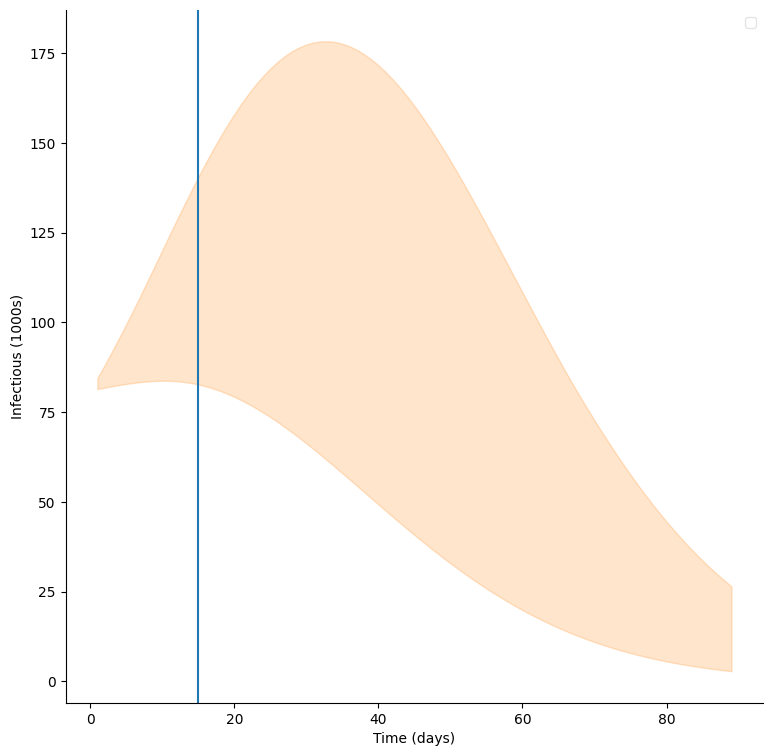

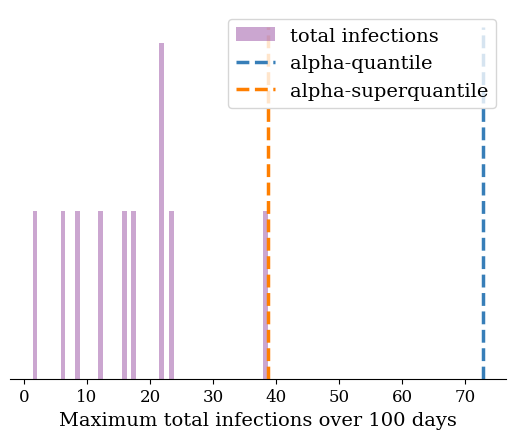

In [10]:
ax = setup_ax()
ax = plot_predictive(sq_dataCube, full_tspan, ax=ax, color=co[1])
ax.axvline(15)
sideaxis(ax)

bins_hist = 50
fig1 = plt.figure()
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=18.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(sq_qoi, color=co[2], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='total infections')
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
cax.vlines(q_sv, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-quantile', color=co[0])
cax.vlines(sq_sv, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-superquantile', color=co[1])
cax.set_xlabel('Maximum total infections over 100 days', size=14)
cax.legend(loc='upper right', prop={'size': 14})

### Setup and run OUU problem

In [11]:
control_model = copy.deepcopy(initialized_petri_net_ode_model)
# Objective function
objfun = lambda x: np.abs(x)

# Define the risk measure.
# TODO: put RISK and CONSTRAINTS inside optimize interface
RISK = computeRisk(model=control_model,
                   interventions=INTERVENTION,
                    qoi=QOI,
                    tspan=full_tspan,
                    risk_measure=lambda z: alpha_superquantile(z, alpha=0.95),
                    num_samples=n_samples_ouu,
                    guide=None
                    )

# Define problem constraints
constraints = (
                # risk constraint
                {'type': 'ineq', 'fun': lambda x: risk_bound - RISK(x)},
                # bounds on control
                {'type': 'ineq', 'fun': lambda x: x - u_min},
                {'type': 'ineq', 'fun': lambda x: u_max - x}
               )

In [12]:
print("Performing risk-based optimization under uncertainty (using alpha-superquantile)...")
print(f"Estimated wait time {time_per_eval*n_samples_ouu*(maxiter+1)*maxfeval:.1f} seconds.")
start_time = time.time()
sq_result_1 = solveOUU(
                     x0=init_guess,
                     objfun=objfun,
                     constraints=constraints,
                     maxiter=maxiter,
                     maxfeval=maxfeval,
                    ).solve()
print(f"Optimization completed in time {time.time()-start_time:.2f} seconds. Optimal solution:\t{sq_result_1.x}")

# Check for some interventions that lead to no feasible solutions
if sq_result_1.x<0:
    print("No solution found")

Performing risk-based optimization under uncertainty (using alpha-superquantile)...
Estimated wait time 167.2 seconds.


## Assess the effect of the optimal control policy under uncertainty
### Optimum value for $\nu^*=0.0476$

In [ ]:
RISK.num_samples = int(1e3) # Using more samples for risk estimation
sq_optimal_prediction = RISK.propagate_uncertainty(sq_result_1.x)
qois_sq = RISK.qoi(sq_optimal_prediction)
sq_est = RISK.risk_measure(qois_sq)
print('Estimated risk at optimal policy', sq_est)

In [ ]:
ax = setup_ax()
ax = plot_predictive(sq_optimal_prediction, tspan, ax=ax, color=co[2], ptiles=[0.0,1.])
plt.title("Optimal alpha parameter intervention \n with risk-based OUU", size=14)
sideaxis(ax)

bins_hist = 50
fig1 = plt.figure()
plt.rc('font', family='serif', size=14.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(qois_sq, color=co[4], bins=bins_hist, histtype='stepfilled', alpha=0.5, density=True)
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
cax.set_xlabel('Maximum total infections over 100 days', size=14)

# ABC::: Exploring the difference between Quantiles and Super-Quantiles

In [ ]:
torch.manual_seed(1)

POLICY = np.array([100.])
N_SAMPLES = 1000

RISK = computeRisk(model=ode_model,
                 intervention_fun=lambda x: constant_intervention_builder("SV_flux", torch.from_numpy(x), new_tspan),
                 qoi=lambda y: nday_rolling_average(y, contexts=["I_obs"]),
                 risk_measure=alpha_superquantile,
                 num_samples=N_SAMPLES,
                 model_state=final_observed_state,
                 tspan=new_tspan,
                 guide=guide
                )

start_time = time.time()
sq_dataCube = RISK.propagate_uncertainty(POLICY)
end_time = time.time()
forward_time = end_time - start_time
time_per_eval = forward_time / N_SAMPLES
print(f"Forward UQ took {forward_time:.2f} seconds total ({forward_time/N_SAMPLES:.2e} seconds per model evaluation).")
sq_qoi = RISK.qoi(sq_dataCube)
sq_sv = RISK.risk_measure(sq_qoi)

RISK.risk_measure = alpha_quantile
q_sv = RISK(POLICY)

In [ ]:
bins_hist = 50
fig1 = plt.figure()
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=18.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(sq_qoi, color=co[2], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='total infections')
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
cax.vlines(q_sv, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-quantile', color=co[0])
cax.vlines(sq_sv, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-superquantile', color=co[1])
cax.set_xlabel('7-day average infections at 90 days', size=20)
cax.legend(loc='upper right', prop={'size': 20})
plt.show()

## Risk-based optimization under uncertainty with intervention on vaccination rate parameter $\nu$
**NOTE:** This is a demonstration of the interface, optimization is not run to convergence nor are enough samples generated to accurately estimate the risk, so take the results with a grain of salt.

In [ ]:
from pyciemss.risk.ouu import RandomDisplacementBounds, computeRisk, solveOUU
from pyciemss.risk.qoi import nday_rolling_average
from pyciemss.risk.risk_measures import alpha_superquantile, alpha_quantile
import scipy

# Define problem specifics.
risk_bound = 250.
X_MIN = 0.
X_MAX = 0.95

N_SAMPLES = int(5e2)
MAXITER = 10
TOL = 1e-5

RISK_ALPHA = 0.9

# Control action / intervention.
INIT_ITERATE = 0.75
INTERVENTION = lambda x: constant_intervention_builder("nu", x, new_tspan)

# Objective function.
OBJFUN = lambda x: x  # minimize the scalar value itself.

# Define the risk measure.
VAX_RISK = computeRisk(
                        model=noisy_ode_model,
                        intervention_fun=INTERVENTION,
                        qoi=lambda y: nday_rolling_average(y, contexts=["I_obs"]),
                        model_state=final_observed_state,
                        tspan=new_tspan,
                        risk_measure=lambda z: alpha_superquantile(z, alpha=RISK_ALPHA),
                        num_samples=N_SAMPLES,
                        guide=guide,
                        )

# Define problem constraints.
CONSTRAINTS = (
                # risk constraint
                {'type': 'ineq', 'fun': lambda x: risk_bound - VAX_RISK(x)},

                # bounds on control
                # NOTE: perhaps use scipy.optimize.LinearConstraint in the future
                {'type': 'ineq', 'fun': lambda x: x - X_MIN},
                {'type': 'ineq', 'fun': lambda x: X_MAX - x}
               )

In [ ]:
# Go do the dang thing.
print("Performing risk-based optimization under uncertainty ...")
print(f"Estimated wait time {time_per_eval*N_SAMPLES*MAXITER:.0f} seconds.")
sq_result = solveOUU(
                     x0=INIT_ITERATE,
                     objfun=OBJFUN,
                     constraints=CONSTRAINTS,
                     optimizer_algorithm="COBYLA",
                     tol=TOL,
                     options={
                         "disp": False,
                         "maxiter": MAXITER
                             },
                    ).solve()
print(f"Optimizer finished. Optimal Vaccination rate is:\t{sq_result.x[0]:.4}")
est_risk = VAX_RISK(sq_result.x[0])
print(f"Estimated risk was:\t{est_risk:.2f}")

## Assess the effect of the control policy.

In [ ]:
intervened_prediction = VAX_RISK.propagate_uncertainty(POLICY)
qois = VAX_RISK.qoi(intervened_prediction)

In [ ]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, tmin=7, ax=ax, label="No Intervention")
ax = plot_predictive(intervened_prediction, new_tspan, ax=ax, color='red', label="Vaccination Rate Parameter Intervention")
ax = plot_intervention_line(7., ax=ax)


In [ ]:
bins_hist = 50
fig1 = plt.figure()
# plt.rc('text')
plt.rc('font', family='serif', size=18.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(qois, color=co[2], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='total infections (intervened)', density=True)
cax.hist(VAX_RISK.qoi(posterior_prediction), color=co[4], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='do nothing', density=True)
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
cax.vlines(est_risk, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-superquantile', color=co[1])
cax.set_xlabel('7-day average infections at 90 days', size=20)
cax.legend(loc='upper right', prop={'size': 20})
plt.show()